In [1]:
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
trump_df = pd.read_csv('data/trump_tweets.csv', dtype={'id': np.int64}, index_col='id')
trump_df['datetime'] = pd.to_datetime(trump_df['datetime'])
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df.head()

,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
id,,,,,,,,,
98454970654916608,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02 18:07:48+00:00,False,2011-08-02
1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50+00:00,False,2020-03-03
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47+00:00,False,2020-01-17
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58+00:00,False,2020-09-12
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17 13:13:59+00:00,False,2020-01-17


In [4]:
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56571 entries, 98454970654916608 to 1319345719829008384
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        56571 non-null  object             
 1   is_retweet  56571 non-null  bool               
 2   is_deleted  56571 non-null  bool               
 3   device      56571 non-null  object             
 4   favorites   56571 non-null  int64              
 5   retweets    56571 non-null  int64              
 6   datetime    56571 non-null  datetime64[ns, UTC]
 7   is_flagged  56571 non-null  bool               
 8   date        56571 non-null  datetime64[ns]     
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(2)
memory usage: 3.2+ MB


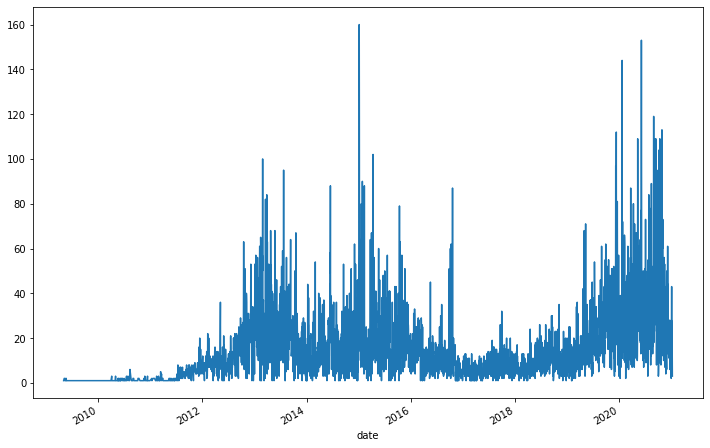

In [5]:
trump_df.groupby('date')['text'].count().plot(figsize=(12, 8));

In [6]:
trump_df = trump_df.query("date >= '2019-01-01' and date < '2022-01-01'")
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20210 entries, 1234653427789070336 to 1319345719829008384
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        20210 non-null  object             
 1   is_retweet  20210 non-null  bool               
 2   is_deleted  20210 non-null  bool               
 3   device      20210 non-null  object             
 4   favorites   20210 non-null  int64              
 5   retweets    20210 non-null  int64              
 6   datetime    20210 non-null  datetime64[ns, UTC]
 7   is_flagged  20210 non-null  bool               
 8   date        20210 non-null  datetime64[ns]     
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(2)
memory usage: 1.1+ MB


In [7]:
trump_df['text'].head()

id
1234653427789070336    I was thrilled to be back in the Great city of...
1218010753434820608    RT @CBS_Herridge: READ: Letter to surveillance...
1304875170860015616    The Unsolicited Mail In Ballot Scam is a major...
1218159531554897920    RT @MZHemingway: Very friendly telling of even...
1217962723234983936    RT @WhiteHouse: President @realDonaldTrump ann...
Name: text, dtype: object

In [8]:
trump_df[trump_df['text'].apply(lambda v: not not re.match('http', v))].text

id
1319501865625784320    https://t.co/4qwCKQOiOw
1319500520126664704    https://t.co/VlEu8yyovv
1319500501269041152    https://t.co/z5CRqHO8vg
1319500486370877440    https://t.co/TQCQiDrVOB
1345958851795951616    https://t.co/NmdLNsfDU2
                                ...           
1084153087785349248    https://t.co/3IH1yW2eTg
1082823394234716160    https://t.co/Ft6FqQmYfI
1080923073820282752    https://t.co/jsOrDtwdEa
1080858959404240768    https://t.co/JzfXMAPwKP
1213316570606428160    https://t.co/qOi7mpKcHY
Name: text, Length: 1244, dtype: object

In [9]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [10]:
empty_tweets = (
    trump_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(trump_df[empty_tweets].shape)
trump_df[empty_tweets]

(1560, 9)


,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
id,,,,,,,,,
1319501865625784320,https://t.co/4qwCKQOiOw,False,False,Twitter for iPhone,130822,19127,2020-10-23 04:52:14+00:00,False,2020-10-23
1319500520126664704,https://t.co/VlEu8yyovv,False,False,Twitter for iPhone,153446,20275,2020-10-23 04:46:53+00:00,False,2020-10-23
1319500501269041152,https://t.co/z5CRqHO8vg,False,False,Twitter for iPhone,102150,14815,2020-10-23 04:46:49+00:00,False,2020-10-23
1319500486370877440,https://t.co/TQCQiDrVOB,False,False,Twitter for iPhone,255804,35594,2020-10-23 04:46:45+00:00,False,2020-10-23
1319496349092511488,RT @EricTrump: https://t.co/NcrNdOSfIV,True,False,Twitter for iPhone,0,8921,2020-10-23 04:30:19+00:00,False,2020-10-23
...,...,...,...,...,...,...,...,...,...
1082823394234716160,https://t.co/Ft6FqQmYfI,False,False,Twitter for iPhone,128589,31456,2019-01-09 02:16:29+00:00,False,2019-01-09
1080923073820282752,https://t.co/jsOrDtwdEa,False,False,Twitter Media Studio,104658,34605,2019-01-03 20:25:18+00:00,False,2019-01-03
1080858959404240768,https://t.co/JzfXMAPwKP,False,False,Twitter for iPhone,174438,43163,2019-01-03 16:10:31+00:00,False,2019-01-03


In [11]:
trump_df = trump_df[~empty_tweets]
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 1234653427789070336 to 1319345719829008384
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        18650 non-null  object             
 1   is_retweet  18650 non-null  bool               
 2   is_deleted  18650 non-null  bool               
 3   device      18650 non-null  object             
 4   favorites   18650 non-null  int64              
 5   retweets    18650 non-null  int64              
 6   datetime    18650 non-null  datetime64[ns, UTC]
 7   is_flagged  18650 non-null  bool               
 8   date        18650 non-null  datetime64[ns]     
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(2)
memory usage: 1.0+ MB


In [12]:
tweet_words = collections.Counter()
trump_df.text.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v not in set(stop_words)]).apply(tweet_words.update)
len(tweet_words), tweet_words.most_common(50)

(17529,
 [('great', 2477),
  ('president', 2420),
  ('trump', 1830),
  ('people', 1533),
  ('democrats', 1363),
  ('thank', 1249),
  ('biden', 1128),
  ('amp', 1087),
  ('news', 1085),
  ('new', 1020),
  ('country', 933),
  ('big', 911),
  ('would', 848),
  ('fake', 846),
  ('never', 843),
  ('get', 842),
  ('america', 839),
  ('american', 823),
  ('joe', 787),
  ('today', 786),
  ('election', 757),
  ('one', 733),
  ('vote', 722),
  ('many', 717),
  ('media', 690),
  ('years', 667),
  ('time', 666),
  ('states', 664),
  ('like', 663),
  ('want', 658),
  ('impeachment', 657),
  ('even', 646),
  ('house', 622),
  ('state', 621),
  ('china', 605),
  ('going', 580),
  ('done', 569),
  ('nothing', 565),
  ('back', 557),
  ('good', 555),
  ('u', 542),
  ('us', 539),
  ('much', 537),
  ('job', 529),
  ('make', 522),
  ('border', 521),
  ('united', 510),
  ('win', 495),
  ('must', 485),
  ('republican', 482)])

In [13]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=5000,
    preprocessor=text_preprocessor
)
tfidf_vectorizer.fit(trump_df.text)
len(tfidf_vectorizer.vocabulary_)

5000

In [14]:
text_tfidf = tfidf_vectorizer.transform(trump_df.text).toarray()

In [15]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_tfidf)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_tfidf)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_tfidf)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: user 3min 20s, sys: 17 s, total: 3min 37s
Wall time: 1min 24s


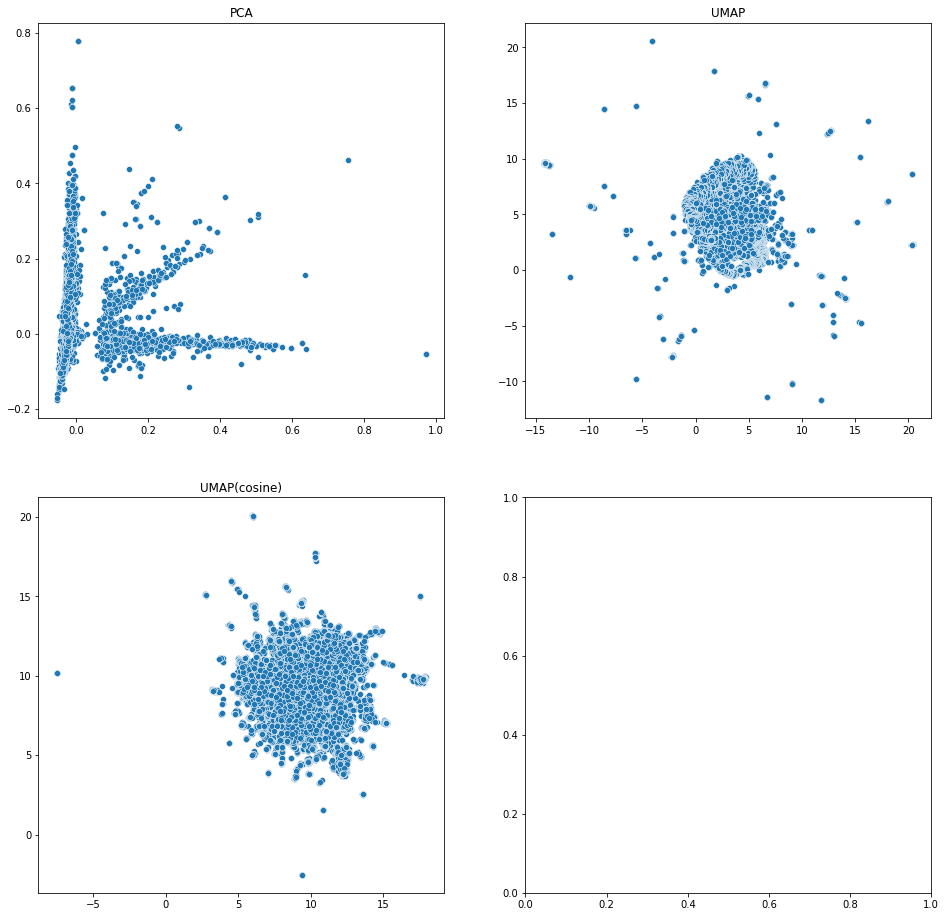

In [16]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [17]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_tfidf)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_tfidf, kmeans.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 15/15 [18:52<00:00, 75.49s/it]


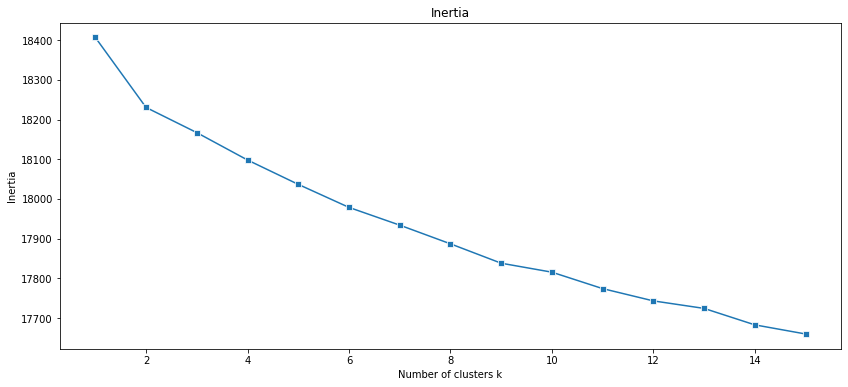

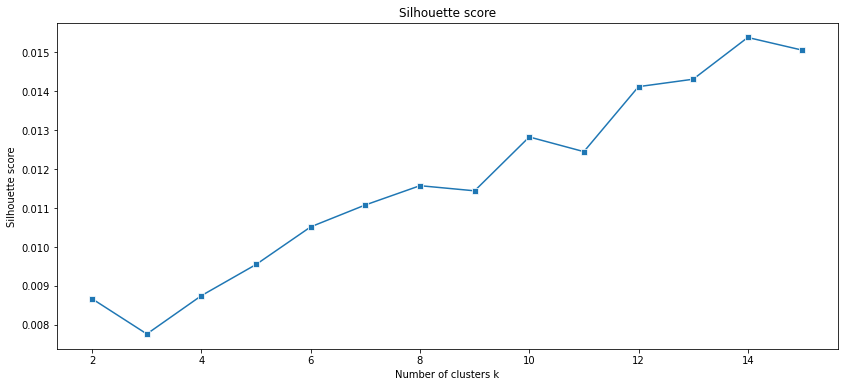

In [18]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [19]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

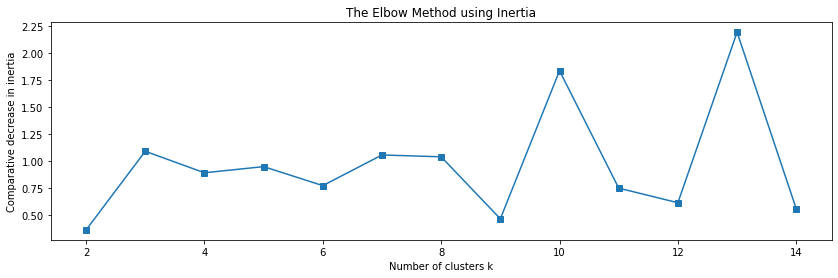

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys()), list(d.values()), marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [17]:
kmeans = KMeans(
    n_clusters=2,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_tfidf)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

2


In [18]:
# kmeans = DBSCAN(
#     # n_clusters=2
#     eps=0.6,
#     metric='cosine'
# )
# clusters = kmeans.fit_predict(text_tfidf)
# print(len(set(clusters)))

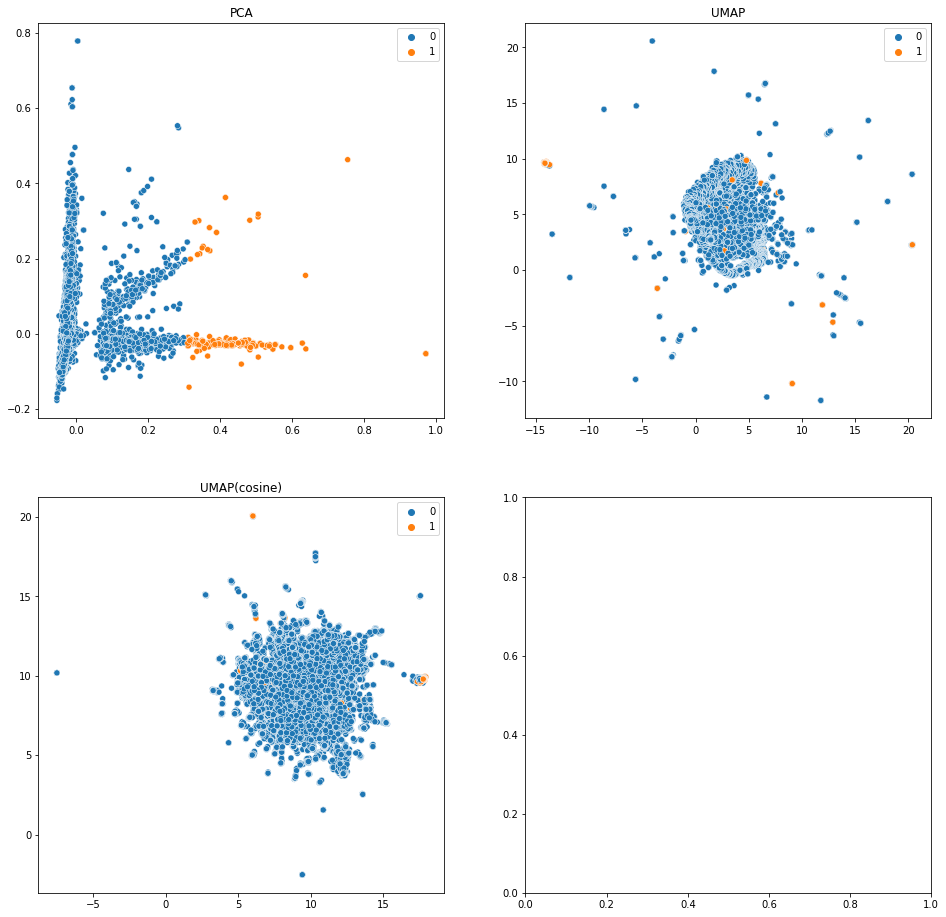

In [19]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [20]:
trump_df['cluster'] = clusters

In [21]:
trump_df.groupby('cluster')['cluster'].count()

cluster
0    18203
1      447
Name: cluster, dtype: int64

In [22]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v in tfidf_vectorizer.vocabulary_]).apply(words_counter.update)
    return words_counter.most_common(25)

In [23]:
trump_df.query('cluster == 0').head(10)

,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster
id,,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50+00:00,False,2020-03-03,0
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47+00:00,False,2020-01-17,0
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58+00:00,False,2020-09-12,0
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17 13:13:59+00:00,False,2020-01-17,0
1217962723234983936,RT @WhiteHouse: President @realDonaldTrump ann...,True,False,Twitter for iPhone,0,25048,2020-01-17 00:11:56+00:00,False,2020-01-17,0
1223640662689689600,Getting a little exercise this morning! https:...,False,False,Twitter for iPhone,285863,30209,2020-02-01 16:14:02+00:00,False,2020-02-01,0
1236502342121541632,RT @GOPChairwoman: The economic boom continues...,True,False,Twitter for iPhone,0,8681,2020-03-08 04:01:46+00:00,False,2020-03-08,0
1225835449379258368,RT @TomFitton: Vindman's behavior is a scandal...,True,False,Twitter for iPhone,0,7679,2020-02-07 17:35:20+00:00,False,2020-02-07,0
1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",False,False,Twitter for iPhone,253761,79855,2020-10-23 04:09:59+00:00,False,2020-10-23,0


In [24]:
print_top_n_words(trump_df.query('cluster == 0').text)

[('great', 2454),
 ('president', 2416),
 ('trump', 1829),
 ('people', 1533),
 ('democrats', 1363),
 ('biden', 1128),
 ('amp', 1086),
 ('news', 1082),
 ('new', 1016),
 ('country', 933),
 ('big', 910),
 ('would', 848),
 ('fake', 845),
 ('get', 842),
 ('never', 840),
 ('america', 838),
 ('american', 823),
 ('thank', 797),
 ('today', 786),
 ('joe', 785),
 ('election', 757),
 ('one', 731),
 ('vote', 720),
 ('many', 716),
 ('media', 690)]

In [25]:
trump_df.query('cluster == 1').head(10)

,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster
id,,,,,,,,,,
1215247978966986752,Thank you Elise! https://t.co/Y4Hb0zf5jk,False,False,Twitter for iPhone,48510,11608,2020-01-09 12:24:31+00:00,False,2020-01-09,1
1319655865083940864,Thank you Megyn! https://t.co/sC71EEWIOd,False,False,Twitter for iPhone,178163,24864,2020-10-23 15:04:10+00:00,False,2020-10-23,1
1320134156035174400,THANK YOU OHIO! #VOTE \nhttps://t.co/5EJjFZVLHZ,False,False,Twitter for iPhone,57305,9852,2020-10-24 22:44:44+00:00,False,2020-10-24,1
1317060388371025920,Thank you! https://t.co/ceq1n14MYa,False,False,Twitter for iPhone,41882,7722,2020-10-16 11:10:41+00:00,False,2020-10-16,1
1320162439200149504,Thank you OHIO! #VOTE\nhttps://t.co/gsFSghkmdM...,False,False,Twitter for iPhone,74088,12731,2020-10-25 00:37:07+00:00,False,2020-10-25,1
1320190644401352704,THANK YOU WISCONSIN!\nhttps://t.co/nOcUhuuNoF,False,False,Twitter for iPhone,65024,11259,2020-10-25 02:29:12+00:00,False,2020-10-25,1
1329771800369225728,"Thank you Elizabeth, LOVE! https://t.co/iopJ0A...",False,False,Twitter for iPhone,118257,19945,2020-11-20 13:01:17+00:00,False,2020-11-20,1
1320043672197619712,RT @realDonaldTrump: Thank you Megyn!,True,False,Twitter for iPhone,0,24708,2020-10-24 16:45:11+00:00,False,2020-10-24,1
1320432705121652736,THANK YOU NEW HAMPSHIRE!\nhttps://t.co/XEoCm4v1M5,False,False,Twitter for iPhone,60488,10163,2020-10-25 18:31:04+00:00,False,2020-10-25,1


In [26]:
print_top_n_words(trump_df.query('cluster == 1').text)

[('thank', 452),
 ('maga', 62),
 ('kag2020', 25),
 ('great', 23),
 ('pennsylvania', 14),
 ('love', 10),
 ('nice', 8),
 ('michigan', 7),
 ('florida', 7),
 ('job', 7),
 ('wisconsin', 6),
 ('much', 6),
 ('ohio', 5),
 ('mark', 5),
 ('john', 5),
 ('mike', 5),
 ('true', 5),
 ('new', 4),
 ('hampshire', 4),
 ('matt', 4),
 ('david', 4),
 ('wonderful', 4),
 ('james', 4),
 ('president', 4),
 ('bill', 4)]

In [27]:
trump_df.query('cluster == 2').head(10)

,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster
id,,,,,,,,,,


In [28]:
print_top_n_words(trump_df.query('cluster == 2').text)

[]

In [ ]:
# EPS = np.linspace(0.1, 5, 6)

# silhouette = {}
# clusters = {}

# for eps in tqdm(EPS):
#     dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_tfidf)
#     clusters[eps] = len(set(dbscan.labels_)) - 1
#     # print(set(dbscan.labels_))
#     if len(set(dbscan.labels_)) > 1:
#         # print(eps, set(dbscan.labels_))
#         silhouette[eps] = silhouette_score(text_tfidf, dbscan.labels_)
# # print(silhouette

 33%|███████████████████████▎                                              | 2/6 [01:41<03:09, 47.30s/it]

In [ ]:
# plt.figure(figsize=(14, 6))
# sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

# plt.title('Silhouette score')
# plt.xlabel('eps')
# plt.ylabel('Silhouette score')

# plt.show()

In [ ]:
# plt.figure(figsize=(14, 6))
# sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

# plt.title('Clusters')
# plt.xlabel('eps')
# plt.ylabel('Clusters')

# plt.show()

In [ ]:
# best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
# best_eps